In [75]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#1introduction
#importing libraries

import numpy as np
import pandas as pd
import re
import json
import glob
import spacy
import os
import random
import numpy as np
import tensorflow as tf  # if you are using tensorflow

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim
from bertopic import BERTopic

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [76]:
#importing the Documentt Term Matrix-DTM (collection of documents where each row corresponds to a document and each column represents a unique term (word))
import rpy2.robjects as robjects

readRDS = robjects.r['readRDS']
dtm_r = readRDS("clean_dtm.rds")
print(dtm_r)

$i
    [1]   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   [19]   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   [37]   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   [55]   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   [73]   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   [91]   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
  [109]   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
  [127]   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
  [145]   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
  [163]   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
  [181]   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
  [199]   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
  [217]   1   1   1   1   1   1   1  

In [77]:
# Creating DataFrame frpm DTM
from scipy.sparse import coo_matrix

# Data extraction
rows = [x - 1 for x in list(dtm_r.rx2('i'))]
cols = [x - 1 for x in list(dtm_r.rx2('j'))]
data = list(dtm_r.rx2('v'))
nrow = int(dtm_r.rx2('nrow')[0])
ncol = int(dtm_r.rx2('ncol')[0])
terms = list(dtm_r.rx2('dimnames')[1])
docs = list(dtm_r.rx2('dimnames')[0])

# Creating sparse matrix and convert to dense array
mtx = coo_matrix((data, (rows, cols)), shape=(nrow, ncol)).toarray()

df = pd.DataFrame(mtx, columns=terms, index=docs)
#df.head()  

In [78]:
#creating text string to use for the model
def row_to_text(row):
    words = []
    for col, count in row.items():
        try:
            repetitions = int(count)
        except (ValueError, TypeError):
            repetitions = 0
        if repetitions > 0:
            words.extend([col]*repetitions)
    return ' '.join(words)

texts = df.apply(row_to_text, axis=1).tolist()


In [79]:
import numpy as np
import random
from bertopic import BERTopic
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import umap

# Set seeds for python and numpy
np.random.seed(42)
random.seed(42)

# Configure UMAP with fixed random state and desired params
umap_model = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1, metric='cosine')

# Encode documents
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(texts, show_progress_bar=True)

# KMeans clustering with fixed random state
kmeans_model = KMeans(n_clusters=9, random_state=42)
predicted_topics = kmeans_model.fit_predict(embeddings)

# Instantiate BERTopic with fixed UMAP model for full reproducibility
topic_model = BERTopic(
    language="english",
    nr_topics=None,
    umap_model=umap_model,
    verbose=True
)

# Fit using precomputed clusters (offline mode)
topics, probs = topic_model.fit_transform(texts, embeddings=embeddings, y=predicted_topics)

# Check topics
print(topic_model.get_topic_info())


Batches:   0%|          | 0/158 [00:00<?, ?it/s]

2025-11-12 17:35:34,368 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-12 17:35:41,015 - BERTopic - Dimensionality - Completed ✓
2025-11-12 17:35:41,018 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-12 17:35:41,124 - BERTopic - Cluster - Completed ✓
2025-11-12 17:35:41,136 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-12 17:35:41,956 - BERTopic - Representation - Completed ✓


    Topic  Count                                         Name  \
0      -1      5                     -1_dam_tower_fire_forest   
1       0    840                  0_animal_wolf_wildlife_year   
2       1    724              1_wildlife_fish_federal_service   
3       2    648                2_federal_wildlife_us_service   
4       3    621                 3_water_fish_california_year   
5       4    593  4_environmental_federal_administration_year   
6       5    526              5_california_fish_water_federal   
7       6    434                      6_court_state_case_vote   
8       7    377                      7_bear_alaska_wolf_year   
9       8    258           8_environmental_year_activist_land   
10      9     28                            9_am_subc_rhob_pm   

                                       Representation  \
0   [dam, tower, fire, forest, burn, klamath, remo...   
1   [animal, wolf, wildlife, year, state, populati...   
2   [wildlife, fish, federal, service, agency, h

In [81]:
# Get a DataFrame of the topic info (includes keywords as a string)
topic_info = topic_model.get_topic_info()

# For more detailed keywords (e.g., list of tokens with weights), you can extract like this:
topic_keywords = []
for topic_num in topic_info['Topic']:
    if topic_num == -1:  # getting rid of the outlier topic
        continue
    keywords = topic_model.get_topic(topic_num)
    # Get just the word list
    word_list = [kw[0] for kw in keywords]
    # Save topic number, full keyword string, and/or list
    topic_keywords.append({'Topic': topic_num, 'keywords': ', '.join(word_list)})

# Make a DataFrame and save to CSV
keywords_df = pd.DataFrame(topic_keywords)
keywords_df.to_csv("wildlife_bertopic_keywords.csv", index=False)


In [82]:
print(keywords_df)

   Topic                                           keywords
0      0  animal, wolf, wildlife, year, state, populatio...
1      1  wildlife, fish, federal, service, agency, habi...
2      2  federal, wildlife, us, service, fish, protect,...
3      3  water, fish, california, year, river, state, s...
4      4  environmental, federal, administration, year, ...
5      5  california, fish, water, federal, state, wildl...
6      6  court, state, case, vote, justice, republican,...
7      7  bear, alaska, wolf, year, polar, state, fish, ...
8      8  environmental, year, activist, land, state, gr...
9      9  am, subc, rhob, pm, dob, approps, office, appr...


In [83]:
keywords_df.to_csv("wildlife_bertopic_keywords.csv", index=False)

In [84]:
# Getting a datframe with topic number, single keyword, and its weight
records = []
for topic_num in topic_model.get_topic_info()['Topic']:
    if topic_num == -1:
        continue  # Skip outlier topic
    for kw, wt in topic_model.get_topic(topic_num):
        records.append({
            "topic": topic_num,
            "keyword": kw,
            "weight": wt
        })

bertopic_keywords_df = pd.DataFrame(records)
bertopic_keywords_df.to_csv("wildlife_bertopic_keywords_with_weights_01.csv", index=False)


In [85]:
#Importing these files so that i dont have to run the model
keywords_df = pd.read_csv('wildlife_bertopic_keywords.csv')

bertopic_keywords_df = pd.read_csv('wildlife_bertopic_keywords_with_weights_01.csv')

doc_topic_df = pd.read_csv('document_topic_mapping.csv')

In [86]:
print(bertopic_keywords_df)

    topic        keyword    weight
0       0         animal  0.029065
1       0           wolf  0.026146
2       0       wildlife  0.021663
3       0           year  0.019931
4       0          state  0.016962
..    ...            ...       ...
95      9        approps  0.062123
96      9         office  0.060734
97      9  appropriation  0.058197
98      9           bldg  0.053067
99      9         affair  0.045656

[100 rows x 3 columns]


In [87]:
doc_topic_df = pd.DataFrame({'GOID': docs, 'Topic': topics})
print(doc_topic_df.head())

        GOID  Topic
0  423968056      6
1  423987935      6
2  423991776      3
3  424019341      2
4  424018521      0


In [88]:
doc_topic_df.to_csv('document_topic_mapping.csv', index=False)

In [89]:
#I want a count of keywords for the wordcloud

keyword_counts = bertopic_keywords_df.groupby('keyword').size().reset_index(name='count')

#print(keyword_counts.sort_values(by='count', ascending=False))

keyword_counts.to_csv('Bertopic_keyword_counts_for_news.csv', index=False)


In [90]:
bert_words = pd.read_csv("wildlife_bertopic_keywords_with_weights_01.csv")
print(bert_words)

    topic        keyword    weight
0       0         animal  0.029065
1       0           wolf  0.026146
2       0       wildlife  0.021663
3       0           year  0.019931
4       0          state  0.016962
..    ...            ...       ...
95      9        approps  0.062123
96      9         office  0.060734
97      9  appropriation  0.058197
98      9           bldg  0.053067
99      9         affair  0.045656

[100 rows x 3 columns]


In [91]:
#trying to check keywords in topic 0
filtered_topic_bertopic = bert_words[bert_words['topic'] == 0]
print(filtered_topic_bertopic)

   topic     keyword    weight
0      0      animal  0.029065
1      0        wolf  0.026146
2      0    wildlife  0.021663
3      0        year  0.019931
4      0       state  0.016962
5      0  population  0.015146
6      0        fish  0.014521
7      0        bird  0.013374
8      0        kill  0.013021
9      0        park  0.012951


In [92]:
# Group keywords by topic, using set for easy overlap checking
bertopic_topics = []
for topic, group in bert_words.groupby('topic'):
    keywords = set(group['keyword'])
    bertopic_topics.append({'topic': topic, 'keywords': keywords})

print(bertopic_topics[:5])  # Shows the first 5 topics in your desired format

[{'topic': 0, 'keywords': {'year', 'population', 'bird', 'wildlife', 'fish', 'kill', 'state', 'park', 'animal', 'wolf'}}, {'topic': 1, 'keywords': {'year', 'wildlife', 'fish', 'list', 'state', 'habitat', 'plan', 'service', 'agency', 'federal'}}, {'topic': 2, 'keywords': {'wildlife', 'fish', 'list', 'service', 'court', 'protection', 'threaten', 'protect', 'us', 'federal'}}, {'topic': 3, 'keywords': {'river', 'year', 'salmon', 'fish', 'state', 'habitat', 'plan', 'water', 'california', 'federal'}}, {'topic': 4, 'keywords': {'government', 'year', 'state', 'house', 'water', 'law', 'environmental', 'agency', 'federal', 'administration'}}]


STM

In [93]:
stm_words = pd.read_csv("news_stm_topic_keywords_with_weights.csv")
print(stm_words)

    topic    keyword    weight
0       1      water  0.041614
1       1      river  0.022201
2       1       fish  0.021578
3       1     salmon  0.019609
4       1       year  0.012008
..    ...        ...       ...
95      9   industry  0.007591
96      9    federal  0.007367
97      9        log  0.007273
98      9        oil  0.007220
99      9  president  0.006944

[100 rows x 3 columns]


In [94]:
#counting keywords in stm

keyword_counts_stm = stm_words.groupby('keyword').size().reset_index(name='count')

#print(keyword_counts_stm)

keyword_counts_stm.to_csv('STM_keyword_counts_for_news.csv', index=False)


In [95]:
#To check the topic and see the weights of the keywords
filtered_topic = stm_words[stm_words['topic'] == 1]
print(filtered_topic)

   topic     keyword    weight
0      1       water  0.041614
1      1       river  0.022201
2      1        fish  0.021578
3      1      salmon  0.019609
4      1        year  0.012008
5      1         dam  0.011465
6      1  california  0.010442
7      1       state  0.010006
8      1     federal  0.009816
9      1      farmer  0.008259


In [96]:
#did this so that i can use it for the cosine similarity
# Group keywords by topic, using set for easy overlap checking
stm_topics = []
for topic, group in stm_words.groupby('topic'):
    keywords = set(group['keyword'])
    stm_topics.append({'topic': topic, 'keywords': keywords})

print(stm_topics[:5])  # Shows the first 5 topics in your desired format


[{'topic': 1, 'keywords': {'river', 'year', 'dam', 'salmon', 'fish', 'farmer', 'state', 'water', 'california', 'federal'}}, {'topic': 2, 'keywords': {'year', 'turtle', 'otter', 'fish', 'butterfly', 'whale', 'marine', 'water', 'sea', 'time'}}, {'topic': 3, 'keywords': {'year', 'senate', 'bill', 'state', 'house', 'vote', 'republican', 'congress', 'environmental', 'clinton'}}, {'topic': 4, 'keywords': {'bear', 'kill', 'year', 'wildlife', 'state', 'park', 'grizzly', 'animal', 'hunt', 'wolf'}}, {'topic': 5, 'keywords': {'wildlife', 'fish', 'list', 'habitat', 'service', 'protection', 'threaten', 'protect', 'agency', 'federal'}}]


COSINE SIMILARITY

In [97]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

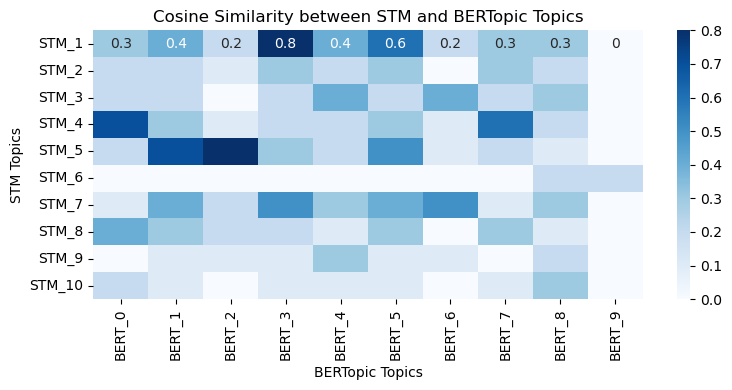

In [98]:
# 1. Unified vocabulary
all_keywords = set()
for t in stm_topics + bertopic_topics:
    all_keywords |= t['keywords']
vocab = sorted(all_keywords)

# 2. Vectorize topics
def to_vector(topic_keywords, vocab):
    return [1 if kw in topic_keywords else 0 for kw in vocab]
stm_vectors = np.array([to_vector(t['keywords'], vocab) for t in stm_topics])
bert_vectors = np.array([to_vector(t['keywords'], vocab) for t in bertopic_topics])

# 3. Compute cosine similarity
similarity_matrix = cosine_similarity(stm_vectors, bert_vectors)

# 4. Plot heatmap
plt.figure(figsize=(8,4))
sns.heatmap(similarity_matrix, annot=True, xticklabels=[f"BERT_{t['topic']}" for t in bertopic_topics], 
            yticklabels=[f"STM_{t['topic']}" for t in stm_topics], cmap="Blues")
plt.title("Cosine Similarity between STM and BERTopic Topics")
plt.xlabel("BERTopic Topics")
plt.ylabel("STM Topics")
plt.tight_layout()
plt.show()

#Made a heatmap in R

METADATA

In [99]:
metadata = pd.read_csv("meta.csv")
metadata.head(1)

,GOID,Title,Date,Source Type,Authors,Publication ID,Publication Title,Publisher City,Publisher Province,Publisher Name,Publisher ZipCode,Object Type,Language,Pages,Start Page,Company Name,Company NAIC,Class Terms,Subject Terms
0,433375738,Park Service To Emphasize Conservation In New ...,2006-08-31,Newspapers,"['Barringer, Felicity']",11561,New York Times,NEW YORK,NY,New York Times Company,10018.0,Articles - All Types,English,0.0,A.16,['National Park Service-US'],['924120'],NaN,"['Conservation', 'Recreation industry', 'Envir..."


In [100]:
metadata.shape

(5241, 19)

In [101]:
#getting oly GOID and Date from metadata
columns_to_keep = ['GOID', 'Date']

# Create a new DataFrame with only these columns
new_df = metadata[columns_to_keep]

print(new_df.head())

        GOID        Date
0  433375738  2006-08-31
1  433422646  2006-10-31
2  433462991  2006-12-28
3  433470077  2006-12-11
4  433481259  2007-01-30


In [102]:
stm_gamma = pd.read_csv("stm_gamma.csv")
stm_gamma.head(2)

,Unnamed: 0,GOID,topic,gamma
0,1,423968056,1,0.002298
1,2,423987935,1,0.001456


In [103]:
stm_gamma.shape

(50540, 4)

In [104]:
#i wanted to filter and check how many topics each GOID has
filtered_row = stm_gamma[stm_gamma['GOID'] == 423968056]
print(filtered_row)

       Unnamed: 0       GOID  topic     gamma
0               1  423968056      1  0.002298
5054         5055  423968056      2  0.168195
10108       10109  423968056      3  0.071988
15162       15163  423968056      4  0.078102
20216       20217  423968056      5  0.075703
25270       25271  423968056      6  0.355744
30324       30325  423968056      7  0.048214
35378       35379  423968056      8  0.003927
40432       40433  423968056      9  0.188588
45486       45487  423968056     10  0.007241


In [105]:
# Make sure the column names match exactly; e.g., 'GOID', 'topic', 'gamma'
# Keep only the row with the highest gamma per GOID..after realising that each document will have 10 topics
best_topic_per_goid = stm_gamma.loc[stm_gamma.groupby('GOID')['gamma'].idxmax()].reset_index(drop=True)

print(best_topic_per_goid.head())

   Unnamed: 0       GOID  topic     gamma
0       47716  109846173     10  0.378097
1       44429  276285002      9  0.604291
2       44430  276531081      9  0.702650
3         265  280504819      1  0.532866
4       15434  280508448      4  0.461570


In [106]:
best_topic_per_goid.dtypes

Unnamed: 0      int64
GOID            int64
topic           int64
gamma         float64
dtype: object

In [107]:
#best_topic_per_goid['GOID'] = best_topic_per_goid['GOID'].astype(str)

In [108]:
best_topic_per_goid.dtypes

Unnamed: 0      int64
GOID            int64
topic           int64
gamma         float64
dtype: object

In [109]:
new_df.head()

,GOID,Date
0,433375738,2006-08-31
1,433422646,2006-10-31
2,433462991,2006-12-28
3,433470077,2006-12-11
4,433481259,2007-01-30


In [110]:
new_df.dtypes

GOID     int64
Date    object
dtype: object

In [111]:
# Merge best_topic_per_goid with new_df on 'GOID'
best_topic_per_goid_merged = best_topic_per_goid.merge(new_df, on='GOID', how='left')

print(best_topic_per_goid_merged.head())


   Unnamed: 0       GOID  topic     gamma        Date
0       47716  109846173     10  0.378097  1998-08-02
1       44429  276285002      9  0.604291  2010-05-14
2       44430  276531081      9  0.702650  2010-05-15
3         265  280504819      1  0.532866  1988-08-31
4       15434  280508448      4  0.461570  1988-09-22


In [112]:
count_topic_1 = best_topic_per_goid[best_topic_per_goid['topic'] == 1].shape[0]
print(count_topic_1)

568


In [113]:
new_df['GOID'] = new_df['GOID'].astype(str)
new_df.dtypes

GOID    object
Date    object
dtype: object

In [114]:
doc_topic_df.dtypes

GOID     object
Topic     int64
dtype: object

In [115]:
#converting both the GOID and Topic to string(object) datatype
doc_topic_df['GOID'] = doc_topic_df['GOID'].astype(str)

doc_topic_df['Topic'] = doc_topic_df['Topic'].astype(str)

In [116]:
import pandas as pd

# Merge DataFrames on 'GOID'
merged_df_bertopic = pd.merge(new_df, doc_topic_df[['GOID', 'Topic']], on='GOID', how='left')

In [117]:
merged_df_bertopic.head()

,GOID,Date,Topic
0,433375738,2006-08-31,4
1,433422646,2006-10-31,0
2,433462991,2006-12-28,7
3,433470077,2006-12-11,0
4,433481259,2007-01-30,7


In [118]:
print(best_topic_per_goid_merged.head())

   Unnamed: 0       GOID  topic     gamma        Date
0       47716  109846173     10  0.378097  1998-08-02
1       44429  276285002      9  0.604291  2010-05-14
2       44430  276531081      9  0.702650  2010-05-15
3         265  280504819      1  0.532866  1988-08-31
4       15434  280508448      4  0.461570  1988-09-22


In [119]:
# Make sure 'topic' is integer with no decimals
merged_df_bertopic['Topic'] = merged_df_bertopic['Topic'].astype('Int64') 

In [120]:
merged_df_bertopic.head()

,GOID,Date,Topic
0,433375738,2006-08-31,4
1,433422646,2006-10-31,0
2,433462991,2006-12-28,7
3,433470077,2006-12-11,0
4,433481259,2007-01-30,7


In [121]:
merged_df_bertopic.to_csv("merged_df_bertopic.csv", index=False)

best_topic_per_goid_merged.to_csv("best_topic_per_goid_merged.csv", index=False)

In [122]:
merged_df_bertopic.columns

Index(['GOID', 'Date', 'Topic'], dtype='object')

In [123]:
print(merged_df_bertopic.columns.tolist())

['GOID', 'Date', 'Topic']


In [124]:
count_topic_0 = merged_df_bertopic[merged_df_bertopic['Topic'] == 3].shape[0]
print(count_topic_0)

621


In [125]:
merged_df_bertopic.shape

(5241, 3)

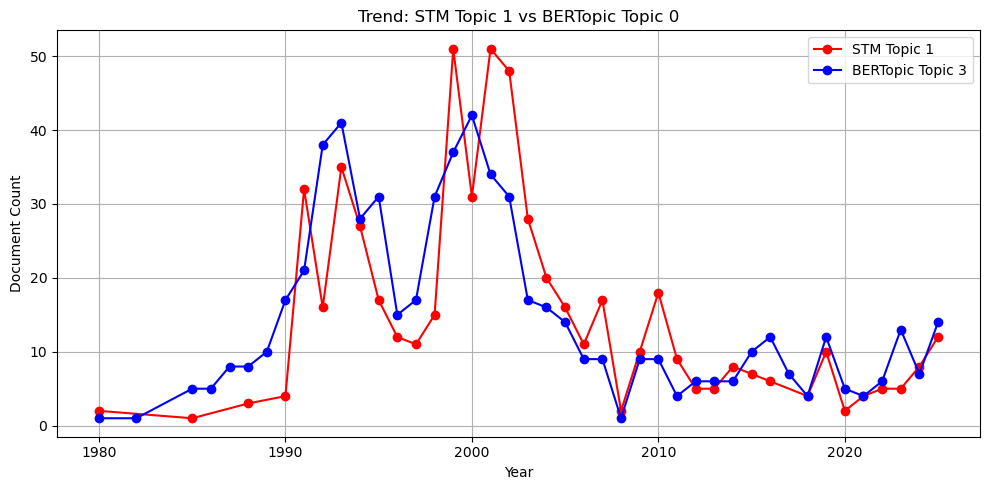

In [126]:
import pandas as pd
import matplotlib.pyplot as plt

# STM
stm_df = best_topic_per_goid_merged.copy()
stm_df['year'] = pd.to_datetime(stm_df['Date']).dt.year
stm_topic1 = stm_df[stm_df['topic'] == 1]
stm_counts = stm_topic1.groupby('year').size()

# BERTopic
bert_df = merged_df_bertopic.copy()
bert_df['year'] = pd.to_datetime(bert_df['Date']).dt.year
bert_topic0 = bert_df[bert_df['Topic'] == 3]
bert_counts = bert_topic0.groupby('year').size()

# Plot
plt.figure(figsize=(10,5))
plt.plot(stm_counts.index, stm_counts.values, marker='o', color='red', label='STM Topic 1')
plt.plot(bert_counts.index, bert_counts.values, marker='o', color='blue', label='BERTopic Topic 3')
plt.xlabel('Year')
plt.ylabel('Document Count')
plt.title('Trend: STM Topic 1 vs BERTopic Topic 0')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
